# 4.3 基于Agent框架的自主飞行---飞进房间

## 新的场景

这一节，我们使用了较为复杂的室内场景：

<img src='img/room_in.jpg' width='640px' />

因为室内无人机需要更小一些，我们专门编译了个版本：

链接：https://pan.baidu.com/s/1mvBZOpPGSSYG5Iqv7sQduA?pwd=3pkn 提取码：3pkn --来自百度网盘超级会员V6的分享

无人机新的任务，包括飞进屋子里，搜索屋内的目标。

## 函数改造

主要是参考SmolAgents的自定义函数样式，对airsim_wrapper.py改造即可：

```python

from smolagents import tool
import math
from typing import Optional, Tuple



@tool
def calculate_cargo_travel_time(
    origin_coords: Tuple[float, float],
    destination_coords: Tuple[float, float],
    cruising_speed_kmh: Optional[float] = 750.0,  # 货运飞机的平均速度
) -> float:
    """
    Calculate the travel time for a cargo plane between two points on Earth using great-circle distance.

    Args:
        origin_coords: Tuple of (latitude, longitude) for the starting point
        destination_coords: Tuple of (latitude, longitude) for the destination
        cruising_speed_kmh: Optional cruising speed in km/h (defaults to 750 km/h for typical cargo planes)

    Returns:
        float: The estimated travel time in hours

    Example:
        >>> # Chicago (41.8781° N, 87.6298° W) to Sydney (33.8688° S, 151.2093° E)
        >>> result = calculate_cargo_travel_time((41.8781, -87.6298), (-33.8688, 151.2093))
    """

    def to_radians(degrees: float) -> float:
        return degrees * (math.pi / 180)

    # 提取坐标
    lat1, lon1 = map(to_radians, origin_coords)
    lat2, lon2 = map(to_radians, destination_coords)

    # 地球半径（公里）
    EARTH_RADIUS_KM = 6371.0

    # 使用半正矢公式计算大圆距离
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.asin(math.sqrt(a))
    distance = EARTH_RADIUS_KM * c

    # 增加10%以考虑非直接路线和空中交通管制
    actual_distance = distance * 1.1

    # 计算飞行时间
    # 为起飞和着陆程序增加1小时
    flight_time = (actual_distance / cruising_speed_kmh) + 1.0

    # 格式化结果
    return round(flight_time, 2)


print(calculate_cargo_travel_time((41.8781, -87.6298), (-33.8688, 151.2093)))
    
```



函数注释格式属于 **Google风格文档字符串规范**（Google Style Docstrings），这是Python社区广泛使用的三大主流文档字符串格式之一（另两种为Numpy风格和reStructuredText风格）。以下是具体分析及规范要点：

---

### **一、规范特征解析**
1. **段落结构**  
   • 使用明确的段落标题（如 `Args`、`Returns`、`Example`）分隔不同内容
   • 标题无缩进且以冒号结尾（如 `Args:`），符合Google风格惯例

2. **参数与返回值说明**  
   • 参数列表中每个条目标注**类型**和**描述**（如 `origin_coords: Tuple[float, float]`）
   • 返回值说明包含类型和含义（如 `float: The estimated travel time in hours`）

3. **示例代码块**  
   • 通过 `Example` 段落提供调用示例，使用 `>>>` 符号表示交互式命令行代码

4. **类型注解增强**  
   • 结合Python类型注解（如 `Tuple[float, float]`）明确参数类型
   • 可选参数标注 `Optional` 并设置默认值（如 `cruising_speed_kmh: Optional[float] = 750.0`）



该注释格式在可读性、工具兼容性上表现优秀，适用于需要清晰API说明的库或团队协作项目。

改造完成的文件为 airsim_smol_wrapper.py

In [1]:
# !pip install smolagents[litellm]
from smolagents import CodeAgent, LiteLLMModel

model = LiteLLMModel(
    model_id="volcengine/doubao-1-5-pro-32k-250115", # This model is a bit weak for agentic behaviours though
    api_base="https://ark.cn-beijing.volces.com/api/v3", # replace with 127.0.0.1:11434 or remote open-ai compatible server if necessary
    api_key="ffd77d7c-f420-4b69-8557-80e7fa85c8b9", # replace with API key if necessary，写自己的key
    flatten_messages_as_text=True, #不写多步骤可能会出错
)

In [2]:
#import litellm
#litellm._turn_on_debug()

In [3]:
from airsim_smol_wrapper import *
refer_info = """
想象一下您正在帮助我与 AirSim 模拟器进行交互。

我们正在控制一个实体Agent。在任何给定时间点，您都具有以下能力。您还需要输出某些请求的代码。
问题 - 向我提出一个澄清问题
原因 - 解释你为什么这样做。
代码 - 输出达到预期目标的代码命令。

除了工具库外，您还可以使用 Python 库中的函数，例如 math、numpy 等。准备好了吗？
"""

In [13]:
agent = CodeAgent(tools=[takeoff,land], model=model)

In [14]:
agent.run(
    "起飞无人机",
    additional_args={"refer_info":refer_info}
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 起飞无人机                                                                                                      │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'refer_info': '\n想象一下您正在帮助我与 AirSim                                                                 │
│ 模拟器进行交互。\n\n我们正在控制一个实体Agent。在任何给定时间点，您都具有以下能力。您还需要输出某些请求的代码。 │
│ \n问题 - 向我提出一个澄清问题\n原因 - 解释你为什么这样做。\n代码 -                                              │
│ 输出达到预期目标的代码命令。\n\n除了工具库外，您还可以使用 Python 库中的函数，例如 math、numpy                  │
│ 等。准备好了吗？\n'}.                                                                                           │
│                                                                                                                 │
╰─ LiteLLMModel - volcengine/doubao-1-5-pro-32k-250115 ───────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  result = takeoff()                                                                                               
  final_answer(result)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[Step 1: Duration 70.22 seconds| Input tokens: 2,373 | Output tokens: 42]


KeyboardInterrupt



In [4]:
takeoff()

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)



'成功'

In [5]:
agent = CodeAgent(tools=[takeoff,get_drone_position, fly_to, fly_path, set_yaw, get_yaw, get_position, look_at,
                        turn_left, turn_right, forward, detect], model=model)

In [6]:
command = """
无人机目前已经起飞了，现在我需要你帮我找到一个门洞。目标可能散布在场景中，请向右转7次，看看它是否变得可见。请探索并找到门洞。
"""

result1 = agent.run(
    command
    #additional_args={"refer_info":refer_info}
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 无人机目前已经起飞了，现在我需要你帮我找到一个门洞。目标可能散布在场景中，请向右转7次，看看它是否变得可见。请探 │
│ 索并找到门洞。                                                                                                  │
│                                                                                                                 │
╰─ LiteLLMModel - volcengine/doubao-1-5-pro-32k-250115 ───────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  for _ in range(7):                                                                                               
      result = turn_right()                                                                                        
      print(f"Turn right result: {result}")                                                                        
                                                                                                                   
  detection_result = detect(object_name="doorway")                                                                 
  print(f"Detection result: {detection_result}")                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Turn right result: 成功
Turn right result: 成功
Turn right result: 成功
Turn right result: 成功
Turn right result: 成功
Turn right result: 成功
Turn right result: 成功
Detection result: (['doorway'], [[429.34759521484375, 182.19842529296875, 735.5948486328125, 522.1348876953125]])

Out: None

[Step 1: Duration 22.56 seconds| Input tokens: 2,850 | Output tokens: 107]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The doorway has been found. Detection result: (['doorway'], [[429.34759521484375,                  
  182.19842529296875, 735.5948486328125, 522.1348876953125]])")                                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The doorway has been found. Detection result: (['doorway'], [[429.34759521484375, 
182.19842529296875, 735.5948486328125, 522.1348876953125]])

[Step 2: Duration 6.17 seconds| Input tokens: 6,072 | Output tokens: 257]

In [7]:
result1

"The doorway has been found. Detection result: (['doorway'], [[429.34759521484375, 182.19842529296875, 735.5948486328125, 522.1348876953125]])"

In [8]:
obj_id_list, obj_locs,img_with_box = detect_with_img("doorway")

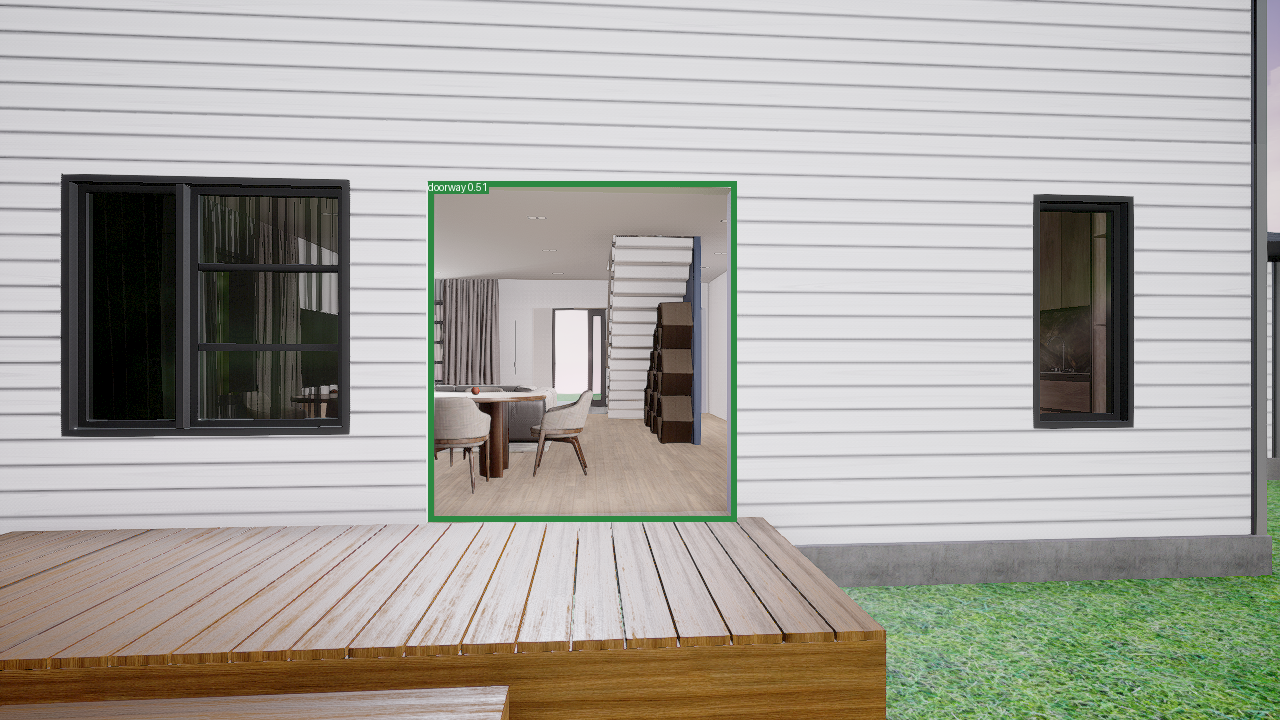

In [9]:
img_with_box

In [12]:
#turn_right()
#set_yaw(0)
#reset()
#get_yaw()

In [10]:
command = """
你已经起飞了，现在需要向前飞5米，进入房间
"""

agent.run(
    command
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 你已经起飞了，现在需要向前飞5米，进入房间                                                                       │
│                                                                                                                 │
╰─ LiteLLMModel - volcengine/doubao-1-5-pro-32k-250115 ───────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  for _ in range(5):                                                                                               
      result = forward()                                                                                           
      print(result)                                                                                                
  final_answer("无人机已向前飞5米进入房间")                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
成功
成功
成功
成功
成功

Out - Final answer: 无人机已向前飞5米进入房间

[Step 1: Duration 13.17 seconds| Input tokens: 2,824 | Output tokens: 88]

'无人机已向前飞5米进入房间'

In [11]:
agent = CodeAgent(tools=[takeoff,get_drone_position, fly_to, fly_path, set_yaw, get_yaw, get_position, look_at,
                        turn_left, turn_right, forward, look], model=model
                  ) 

In [12]:
command = """
好的，现在已经飞进屋子里了，现在能看到屋子里都有啥？
"""

result1 = agent.run(
    command
)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 好的，现在已经飞进屋子里了，现在能看到屋子里都有啥？                                                            │
│                                                                                                                 │
╰─ LiteLLMModel - volcengine/doubao-1-5-pro-32k-250115 ───────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  objects_in_room = look()                                                                                         
  final_answer(f"屋子里能看到的主要物体有：{objects_in_room}")                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 屋子里能看到的主要物体有：电视,沙发,茶几,餐桌,椅子,楼梯,书架,柜子,窗帘,门

[Step 1: Duration 6.54 seconds| Input tokens: 2,798 | Output tokens: 72]